In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
# Loading and preparing the dataset for binary classification
df = pd.read_csv('breast-cancer.csv')

In [7]:
# Selecting two features for visualization and the target variable
X = df[['radius_mean', 'texture_mean']].values
y = df['diagnosis'].map({'M': 1, 'B': 0}).values  # Encode Malignant (1), Benign (0)

In [9]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Normalizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Training SVM models with linear and RBF kernels
linear_svm = SVC(kernel='linear', random_state=42)
rbf_svm = SVC(kernel='rbf', random_state=42)
linear_svm.fit(X_train_scaled, y_train)
rbf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [12]:
# Evaluating models with accuracy and cross-validation
linear_accuracy = accuracy_score(y_test, linear_svm.predict(X_test_scaled))
rbf_accuracy = accuracy_score(y_test, rbf_svm.predict(X_test_scaled))
linear_cv_scores = cross_val_score(linear_svm, X_train_scaled, y_train, cv=5)
rbf_cv_scores = cross_val_score(rbf_svm, X_train_scaled, y_train, cv=5)

In [13]:
# Tuning hyperparameters using GridSearchCV for RBF kernel
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_rbf_svm = grid_search.best_estimator_
best_rbf_accuracy = accuracy_score(y_test, best_rbf_svm.predict(X_test_scaled))

In [14]:
best_rbf_svm

SVC(C=10, gamma=0.1)

In [15]:
# Printing results
print(f"Linear SVM Accuracy: {linear_accuracy:.3f}")
print(f"Linear SVM 5-Fold CV Accuracy: {linear_cv_scores.mean():.3f} (±{linear_cv_scores.std():.3f})")
print(f"RBF SVM Accuracy: {rbf_accuracy:.3f}")
print(f"RBF SVM 5-Fold CV Accuracy: {rbf_cv_scores.mean():.3f} (±{rbf_cv_scores.std():.3f})")
print(f"Best RBF SVM Parameters: {grid_search.best_params_}")
print(f"Best RBF SVM Accuracy: {best_rbf_accuracy:.3f}")


Linear SVM Accuracy: 0.904
Linear SVM 5-Fold CV Accuracy: 0.884 (±0.028)
RBF SVM Accuracy: 0.921
RBF SVM 5-Fold CV Accuracy: 0.899 (±0.036)
Best RBF SVM Parameters: {'C': 10, 'gamma': 0.1}
Best RBF SVM Accuracy: 0.912


In [16]:
# Computing confusion matrix for the best model
best_cm = confusion_matrix(y_test, best_rbf_svm.predict(X_test_scaled))

In [17]:
best_cm

array([[66,  5],
       [ 5, 38]], dtype=int64)

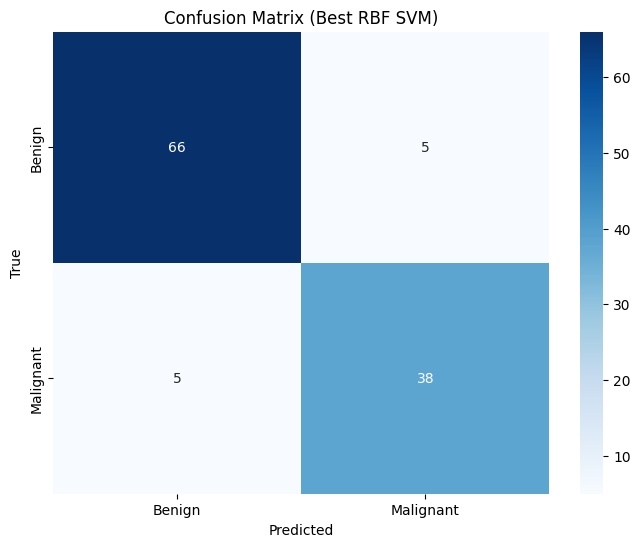

In [18]:
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Best RBF SVM)')
plt.show()

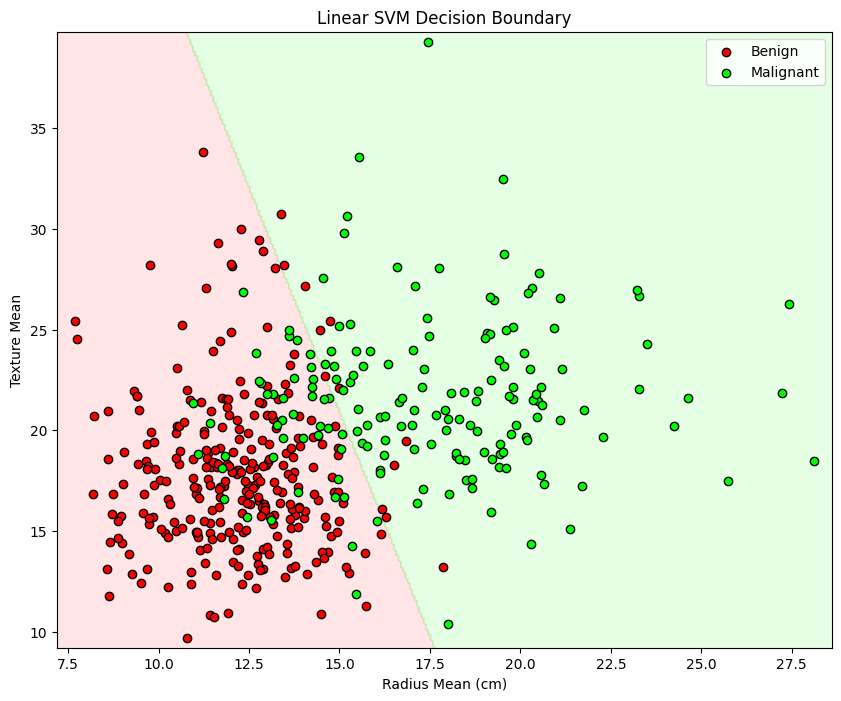

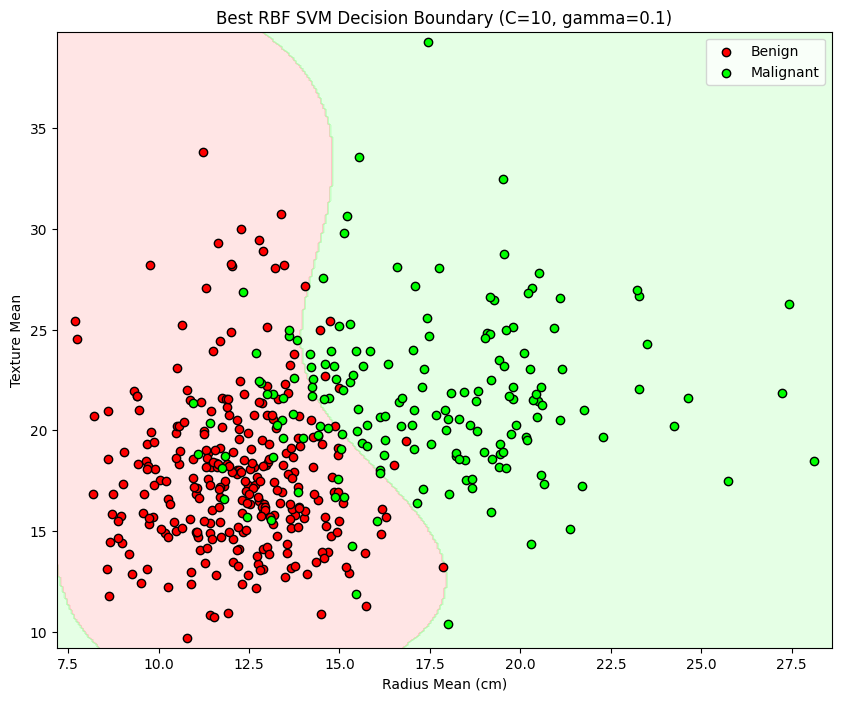

In [19]:
# Visualizing decision boundaries for both models
def plot_decision_boundary(model, X, y, title, scaler):
    h = 0.02  # Step size for mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Predicting on the mesh grid
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Converting back to original scale for plotting
    X_unscaled = scaler.inverse_transform(X)
    xx_unscaled, yy_unscaled = np.meshgrid(
        np.linspace(X_unscaled[:, 0].min() - 0.5, X_unscaled[:, 0].max() + 0.5, xx.shape[1]),
        np.linspace(X_unscaled[:, 1].min() - 0.5, X_unscaled[:, 1].max() + 0.5, xx.shape[0])
    )
    
    # Plotting decision boundary and points
    plt.figure(figsize=(10, 8))
    plt.contourf(xx_unscaled, yy_unscaled, Z, cmap=ListedColormap(['#FFAAAA', '#AAFFAA']), alpha=0.3)
    plt.scatter(X_unscaled[y == 0, 0], X_unscaled[y == 0, 1], c='#FF0000', label='Benign', edgecolor='black')
    plt.scatter(X_unscaled[y == 1, 0], X_unscaled[y == 1, 1], c='#00FF00', label='Malignant', edgecolor='black')
    plt.xlabel('Radius Mean (cm)')
    plt.ylabel('Texture Mean')
    plt.title(title)
    plt.legend()
    plt.show()

# Plotting decision boundaries for linear and best RBF SVM
plot_decision_boundary(linear_svm, X_train_scaled, y_train, 'Linear SVM Decision Boundary', scaler)
plot_decision_boundary(best_rbf_svm, X_train_scaled, y_train, f'Best RBF SVM Decision Boundary (C={grid_search.best_params_["C"]}, gamma={grid_search.best_params_["gamma"]})', scaler)